# Generate datasets to train CNNs to identify number of layers in the time domain

In [1]:
import torch
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add parent directory to the Python path
sys.path.append(str(Path().resolve().parent))

from Simulate import simulate_parallel, simulate_reference


c = 299792458   


def downsample_tensor(tensor, factor):
    """
    Downsamples a 1D tensor by the given factor by taking every nth sample.
    
    Args:
        tensor (torch.Tensor): The input 1D tensor.
        factor (int): The downsampling factor.
        
    Returns:
        torch.Tensor: The downsampled tensor.
    """
    if len(tensor.shape) != 1:
        raise ValueError("Input tensor must be 1D")
    return tensor[::factor]

In [2]:
# Define Example parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)


## Now run Data_gen_efficient.py to get data 

In [3]:
# Load the dataset with weights_only=False
file_path = "Validation_noise_1eneg2.pt"

data = torch.load(f'{file_path}', weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

Dataset loaded successfully!
Number of samples: 10000
Shape of synthetic_data: torch.Size([10000, 1024])
Shape of num_layers: torch.Size([10000])
Example number of layers: tensor([3, 1, 2, 1, 1, 3, 3, 3, 1, 2])


In [7]:
# Check file size
file_size = os.path.getsize(f'{file_path}')

file_size_MB = file_size / (1024*1024)

print(f'File size: {file_size_MB:.2f} MB')

File size: 41.59 MB


## Collect data, plot vs simulations to verify labels

Num layers: 3
Material parameters: [((5.596972857605893-0.029368668533029954j), 0.0004876333749313087), ((5.820813386715411-0.025170492324849678j), 0.0003639542589283998), ((4.804451509575063-0.0035394906557784656j), 0.00010728267912466717)]


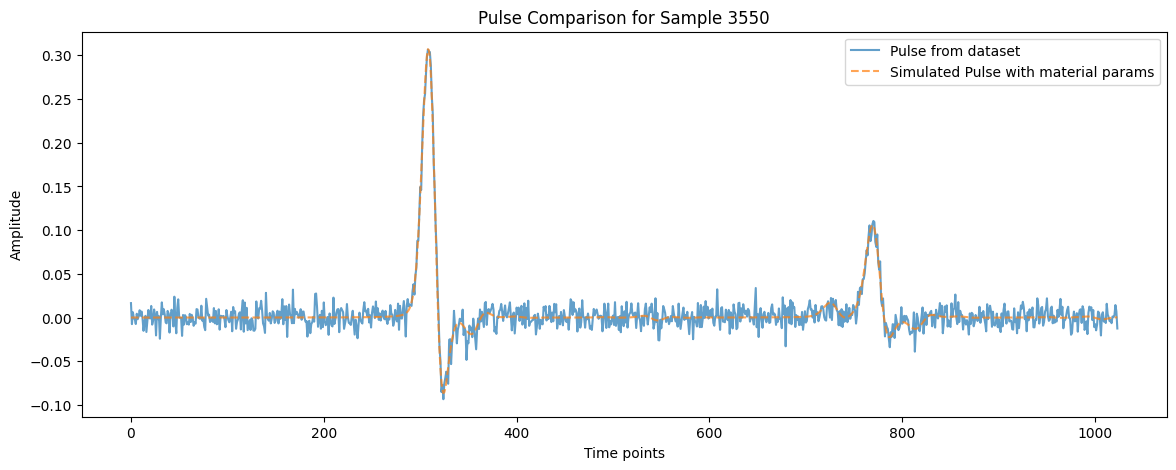

Sample 3550 comparison complete.
Num layers: 3
Material parameters: [((1.520971463565301-0.009592671431968847j), 0.0002563987124801685), ((5.574547858707197-0.013173674694017895j), 0.00014546479248027345), ((2.960622364373166-0.0069627710055804315j), 0.00023492702519280458)]


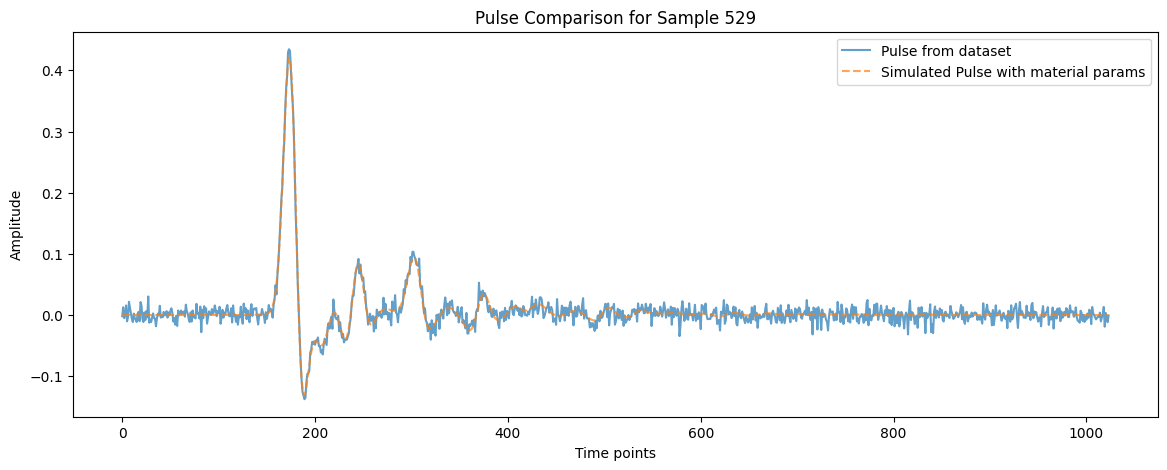

Sample 529 comparison complete.
Num layers: 2
Material parameters: [((5.805373012642592-0.023037599427381608j), 0.00022727927742931307), ((3.529526268405755-0.0942024850108473j), 0.00045180765938086163)]


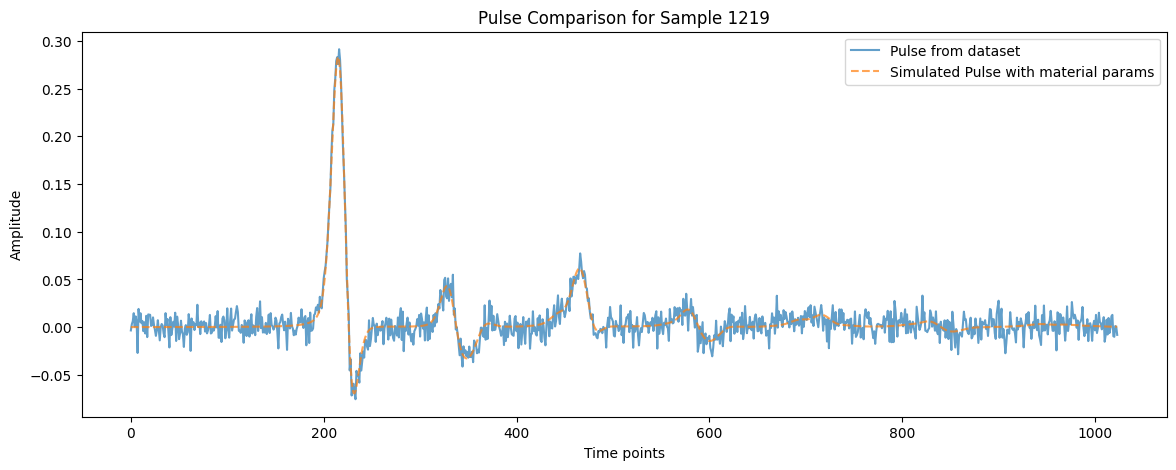

Sample 1219 comparison complete.
Num layers: 3
Material parameters: [((3.5662858065004324-0.08396968428654317j), 8.45719627956122e-05), ((2.4836885558094535-0.023563587979912273j), 0.0002403375427493657), ((4.125400350972713-0.03329235468451382j), 0.0004432527068247197)]


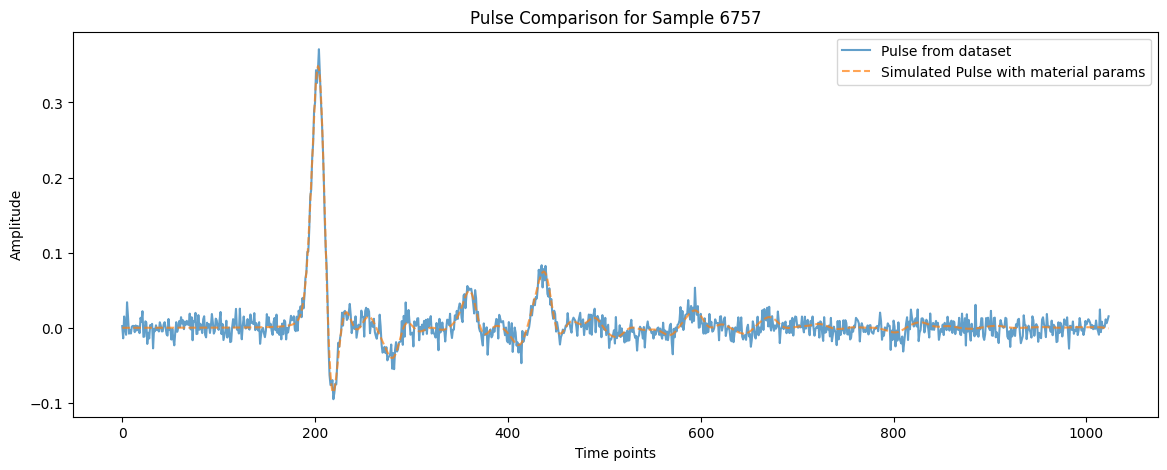

Sample 6757 comparison complete.
Num layers: 1
Material parameters: [((5.9220525503337615-0.013550221068676732j), 0.0001403064074687042)]


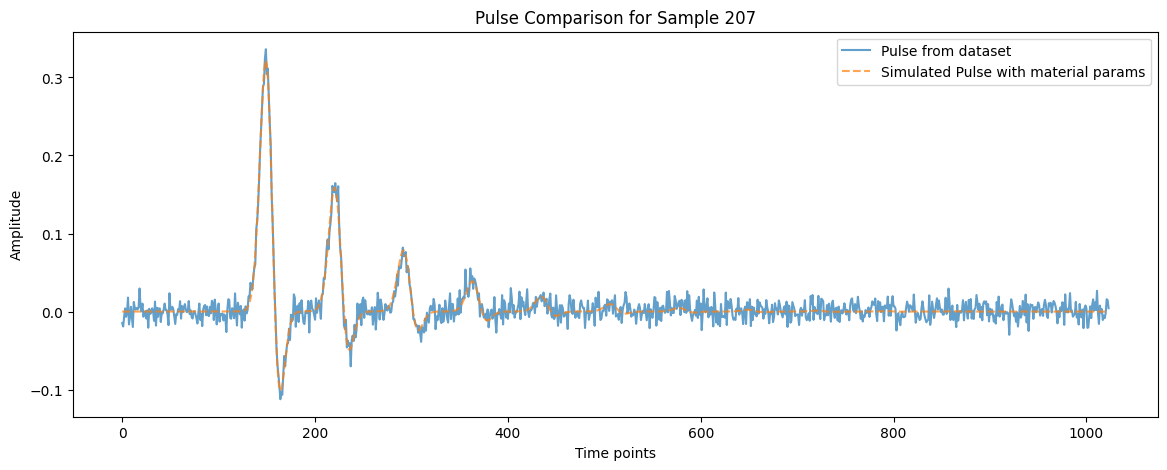

Sample 207 comparison complete.


In [6]:
# Sample 5 random datapoints
num_samples = len(synthetic_data)
random_indices = np.random.choice(num_samples, 5, replace=False)

# Plot the pulses and compare them
for idx in random_indices:
    # Get the material parameters and the reference pulse for this sample
    material_sample = material_params[idx]
    print(f'Num layers: {len(material_sample)}')
    print(f'Material parameters: {material_sample}')
    # Simulate the pulse with the material parameters
    simulated_pulse = simulate_parallel(reference_pulse, material_sample, deltat, 0)[1].detach().cpu()[:L]
    simulated_pulse = downsample_tensor(simulated_pulse, 4)

    # Get the saved pulse from the dataset
    saved_pulse = synthetic_data[idx].cpu()


    # Plot both the simulated pulse and the saved pulse
    plt.figure(figsize=(14, 5))
    plt.plot(saved_pulse, label='Pulse from dataset', alpha=0.7)
    plt.plot(simulated_pulse, label='Simulated Pulse with material params', alpha=0.7, linestyle='--')
    plt.title(f"Pulse Comparison for Sample {idx}")
    plt.xlabel("Time points")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    print(f"Sample {idx} comparison complete.")